In [ ]:
!pip install -q torch transformers scikit-learn pandas matplotlib seaborn lxml tqdm


In [ ]:
!pip install --upgrade transformers


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


In [ ]:
def parse_articles(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    rows = []
    for article in root.findall('article'):
        article_id = article.attrib.get('id')
        title = article.attrib.get('title', '')
        published_at = article.attrib.get('published-at', '')
        text = ' '.join([elem.text.strip() for elem in article.iter() if elem.text and elem is not article])
        rows.append({'id': article_id, 'title': title, 'published_at': published_at, 'text': text.strip()})
    return pd.DataFrame(rows)

def parse_labels(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    rows = []
    for article in root.findall('article'):
        label = 1 if article.attrib.get('hyperpartisan') == "true" else 0
        rows.append({'id': article.attrib['id'], 'label': label})
    return pd.DataFrame(rows)

# Replace with actual file paths if different
articles = parse_articles('articles-training-byarticle-20181122.xml')
labels = parse_labels('ground-truth-training-byarticle-20181122.xml')
df = pd.merge(articles, labels, on='id')
print('Total articles:', len(df))
print(df['label'].value_counts())


Total articles: 645
label
0    407
1    238
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    return text.strip().lower()

df['text_clean'] = df['text'].apply(clean_text)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256

def encode_texts(texts):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

train_enc = encode_texts(X_train)
test_enc  = encode_texts(X_test)


In [ ]:
y_train_tensor = torch.tensor(list(y_train), dtype=torch.long)
y_test_tensor  = torch.tensor(list(y_test), dtype=torch.long)


In [ ]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_enc, list(y_train))
test_dataset  = NewsDataset(test_enc,  list(y_test))


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs'
)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    return {
        'accuracy': (preds == labels).mean(),
        'roc_auc': roc_auc_score(labels, pred.predictions[:,1])
    }

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: priyadharshininagarajan2205 (priyadharshininagarajan2205-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7210891842842102,
 'eval_accuracy': 0.751937984496124,
 'eval_roc_auc': 0.815843621399177,
 'eval_runtime': 95.8643,
 'eval_samples_per_second': 1.346,
 'eval_steps_per_second': 0.177,
 'epoch': 3.0}

In [ ]:
outputs = trainer.predict(test_dataset)
y_true = outputs.label_ids
y_scores = outputs.predictions[:, 1]
y_pred = np.argmax(outputs.predictions, axis=-1)

print(classification_report(y_true, y_pred, digits=4))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.7526    0.9012    0.8202        81
           1     0.7500    0.5000    0.6000        48

    accuracy                         0.7519       129
   macro avg     0.7513    0.7006    0.7101       129
weighted avg     0.7516    0.7519    0.7383       129



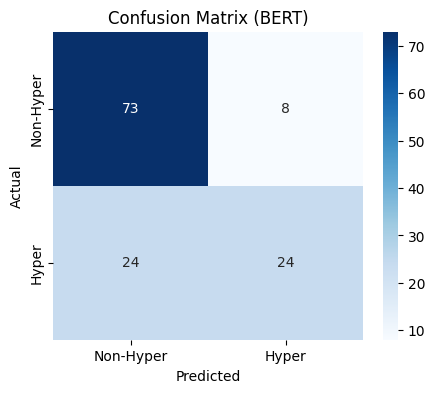

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hyper','Hyper'], yticklabels=['Non-Hyper','Hyper'])
plt.title('Confusion Matrix (BERT)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


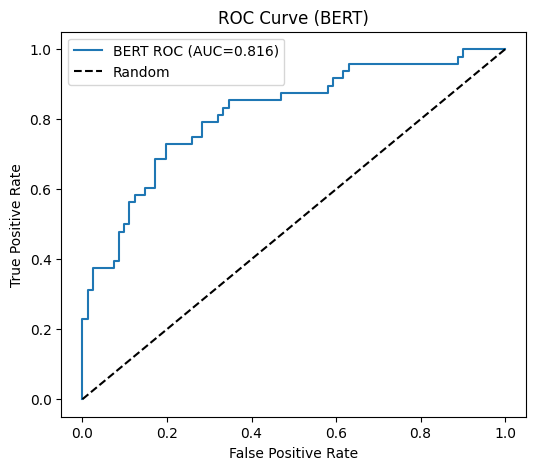

In [ ]:
fpr, tpr, thresh = roc_curve(y_true, y_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'BERT ROC (AUC={roc_auc_score(y_true, y_scores):.3f})')
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (BERT)')
plt.legend(); plt.show()


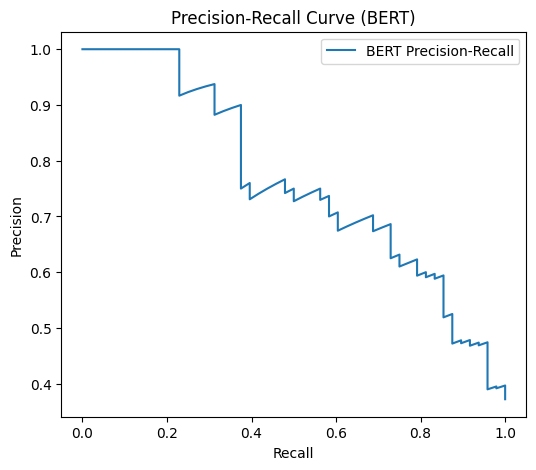

In [ ]:
prec, rec, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label='BERT Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (BERT)')
plt.legend(); plt.show()


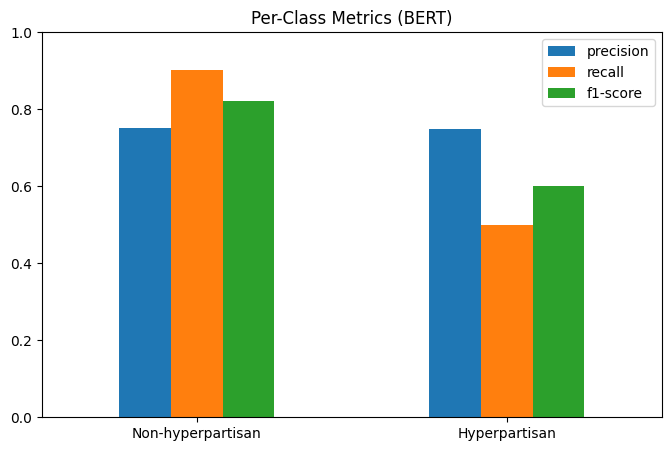

In [ ]:
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
metrics = ['precision','recall','f1-score']
classes = ['Non-hyperpartisan','Hyperpartisan']
scores = [[report[str(i)][metric] for metric in metrics] for i in range(2)]
scores = np.array(scores)

df_scores = pd.DataFrame(scores, columns=metrics, index=classes)
df_scores.plot.bar(rot=0, ylim=(0,1), figsize=(8,5), title='Per-Class Metrics (BERT)')
plt.show()
